In [1]:
# Importing some packages
import os
os.chdir("/Users/ieo5776/Desktop/Garmin_analysis/")

import sys
from typing import Any, Dict, List, Union
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import garth
from garth.exc import GarthException
import seaborn as sns
from scipy import stats

# custom functions
from utils import sleep_functions

# To Do List

1) General analysis on sleep data.
2) focus on an average month vs August for sleep quality
3) Predict sleep score based on the individual scores of each night, i don't think they do it like that but let's see

In [2]:
# Check if connection is still valid, otherwise ask for credentials
GARTH_HOME = "/Users/ieo5776/Desktop/Garmin_analysis"

from garth.exc import GarthException
from getpass import getpass

try:
    garth.resume(GARTH_HOME)
    garth.client.username
except (GarthException, FileNotFoundError):
    email = input("Email: ")
    password = getpass("Password: ")
    garth.client.login(email, password)

garth.save(GARTH_HOME)

#garth.resume("~/.garth")

# Sleep Quality
In this first part, we'll see how's my sleep quality most days. I'll plot the last two years or so, which is roughly the time period in which i've have used my watch (forerunner 955) consistently.  

I'd say i've done a decent job most days. Each orange dot represents a sleep quality value and it's plotted across almost 2 years.
The blue line going thorugh the plot is the `28 day rolling average` which is nicely dancing between 75 and 80, which i don't think it's bad. Also, I'm pretty happy that days below 60 are pretty much rare.  
There's a 0 which i do not trust whatsoever and is definetly missing data. Another option might be starting a night activity without actually going to bed and then erasing it. As far as i remember i was playing around with manually activating the night mode, and that might explain the 0.  


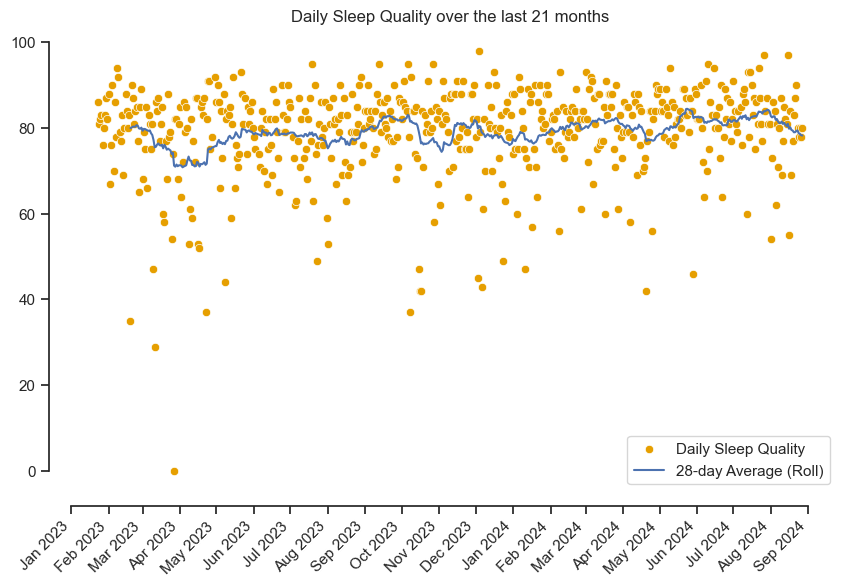

In [3]:
# retrive sleep data
daily_sleep = pd.DataFrame(garth.DailySleep.list(period=365*2))

daily_sleep["calendar_date"] = pd.to_datetime(daily_sleep["calendar_date"])
daily_sleep.set_index("calendar_date", inplace=True)
daily_sleep['rolling_average'] = daily_sleep['value'].rolling(window=28).mean()
daily_sleep

# Plot full sleep data
sleep_functions.plt_sleep(daily_sleep, colors=["#E69F00"])

There's an interesting drop in sleep quality ranging from mid March to mid April. I think this is the combination of a period w/ a greater overall stress from work (let's actually se if this correlates with stress data in the next notebook) and i was preparing for the Milan half marathon, which was on the 24th of March. I think this combination of workload and excessive exercise might have taken its toll on me.

Another interesting factor that contributes to overall sleep quality, is consistency in sleep patters, be it sleep phases of time. Let's see how consistent i have been in the same period

In [4]:
# Gather daily sleep data to find bedtime and wake up time
latest = garth.DailySleep.list(period=2)[-1].calendar_date
sleep_data = [sd.daily_sleep_dto for sd in garth.SleepData.list(latest, 365+(int(365/2)))]

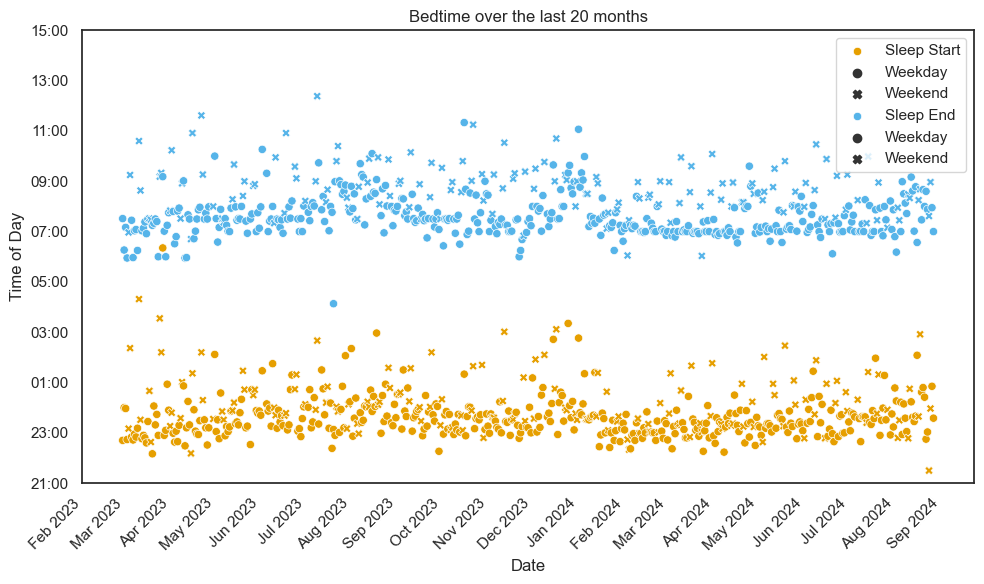

In [ ]:
df = pd.DataFrame(sleep_data)
df.sort_values("calendar_date", inplace=True)
df.set_index("calendar_date", inplace=True)
df["weekdays"] = pd.to_datetime(df.index).day_name().values
df['day_type'] = df["weekdays"].apply(sleep_functions.is_weekend)

# Convert to datatime
df.index = pd.to_datetime(df.index)

# There's time stamps provided but are in milliseconds
start_col = "sleep_start_timestamp_local"
end_col = "sleep_end_timestamp_local"

# Convert to hours and minutes
df["sleep_start"] = pd.to_datetime(df[start_col], unit="ms").dt.time
df["sleep_end"] = pd.to_datetime(df[end_col], unit="ms").dt.time

# Convert to allow 21:00 as the starting point
df["sleep_start_hours"] = df["sleep_start"].apply(sleep_functions.convert_time)
df["sleep_end_hours"] = df["sleep_end"].apply(sleep_functions.convert_time)

# Plot bedtime
sleep_functions.plot_bedtime(df, title="Bedtime over the last 20 months")


Here in blue i'm reporting the time I woke up and in orange the time i fell asleep (not the time i've went to bed). I'm adding another layer of information with crosses indicating weekends and dots indicating weekdays. There's a couple of things to notice:
1) While i try to consistently go to bed around 22:30/22:45, most of the times i don't fall asleep before 23:00. This isn't surprising to me, as i've noticed it usually takes me around 20/30 minutes to fall asleep, unless i'm completely knackered.
2) While i strive to wake up around 7/7:30, i was more inconsistent in the previous (2023) year, as compared to this year (2024). 
3) Although there's a tendecy to fall asleep later at night during weekends, there's a greater difference in the time i wake up. In other words, during weekends, i go to bed later and i sleep more.
4) There's two outliers worth noticing, one bight night out (fell asleep ~ 6:30) and one early flight in the morning in the summer.

In [ ]:
#garth.connectapi("/userprofile-service/userprofile/user-settings")
#garth.UserSettings.get()
#garth.connectapi("/userprofile-service/socialProfile")
#camel_to_snake_dict(garth.connectapi("/userprofile-service/userprofile/user-settings"))